## Pós graduação em inteligência artificial aplicada

### Alunos: Guilherme Oishi Feitosa e Renan Moraes
### Orientador: Johannes 

<h1 align="center"> Tema: Detecção de solonência usando deep learning </h1>

### Introdução ao problema

O problema abordado nesse trabalho será a detecção de sonolência já que este está diretamente relacionado a diversos tipos de acidentes principalmente acidentes de trânsito.

A sonolência é uma das grandes causadores de acidentes, principalmente acidentes de trânsito, segundo uma pesquisa realizada pela Associação Brasileira de Medicina de Tráfego (ABRAMET) em parceria com a Academia Brasileira de Neurologia e o Conselho Regional de Medicina indicou que cerca de 42% dos acidentes de trânsito estão relacionados ao sono (AUTOPAPO, 2019).

Segundo pesquisas dirigir com sono pode ser tão perigoso quanto dirigir alcoolizado (BATISTA, 2017). 

<img src="acidente_sono.jpg" width="500">

Com isso, acredita-se que se houver uma maneira de identificar e alertar o motorista no momento da sonolência, grande parte desses acidentes possam ser evitados.  

### Importando bibliotecas necessárias

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras_efficientnets import EfficientNetB0
from keras.applications.mobilenet import MobileNet
from keras.applications import DenseNet121
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Imagens utilizadas para treinar/testar os modelos

##### Para treinar o modelo foram utilizadas duas categorias de imagens
- Pessoas com os olhos abertos
- Pessoas com os olhos fechados

As imagens de pessoas com olhos abertos foram obtidas no link: https://cswww.essex.ac.uk/mv/allfaces/

Neste link há quatro datasets com fotos de faces de pessoas, a única diferente entre elas é o fundo da imagem, porém como este será removido posteriormente, foram utilizadas duas amostras de cada individuo dos datasets, apenas algumas imagens que apresentavam uma baixa qualidade não foram aproveitadas.

As imagens de pessoas com olhos fechados foram obtidas no link: http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/ClosedEyeDatabases.html

Neste link há um dataset contendo diversas imagens de pessoas com olhos fechados, porém esse dataset está um pouco bagunçado com algumas imagens de pessoas com olhos abertos, então foi necessária uma limpeza, foram removidos esses casos e também foram removidas fotos de crianças e algumas fotos que apresentavam baixa qualidade.

Além dos link apresentados acima, também foram utilizadas algumas fotos dos autores e de alguns amigos

### Definindo função que dado um diretório aplica uma segmentação de face em todas as imagens

In [2]:
def Corta_Face (diretorio, label):
    
    index = 1
    
    # Carregando o modelo de detecção
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Iternado sobre todas as imagens da pasta
    for filename in os.listdir(diretorio):

        # Considerando apenas imagens com extensão .jpg
        if filename.endswith(".jpg"):

            # Mudando o diretório
            os.chdir(diretorio)

            # Lendo a imagem
            img = cv2.imread(filename, cv2.IMREAD_COLOR)

            # Convertendo em escala de cinza
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Detectando o rosto
            faces = face_cascade.detectMultiScale(gray, 1.1, 2)

            if len(faces) != 0: 
                # Cortando o fundo da imagem, deixando apenas a região de interesse
                for (x, y, w, h) in faces:
                    face_crop = img[y:y+h, x:x+w]

                # Definindo nome da nova imagem
                new_filename = label + '_' + str(index) + '.jpg'

                # Ajustando a imagem para 100 x 100
                face_crop = cv2.resize(face_crop, (100, 100))

                # Salvando a imagem cortada
                cv2.imwrite(new_filename, face_crop)    

                # Removendo a imagem original da pasta
                os.remove(filename)

                index = index + 1

            else:
                # Removendo a imagem original da pasta
                os.remove(filename)

        else:
            continue

### Aplicando função corta face nas fotos de olho fechado

In [ ]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\Fotos\Fotos olho fechado'

Corta_Face(directory, "olho_fechado")

### Aplicando função corta face nas fotos de olho aberto

In [ ]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\Fotos\Fotos olho aberto'

Corta_Face(directory, "olho_aberto")

### Data Augmentation

In [3]:
img_width, img_height = 128, 128

Aplicando data augmentation em uma imagem de exemplo para mostrar as tranformações que serão aplicadas posteriormente nas imagens de treino

In [4]:
example_datagen = ImageDataGenerator(rotation_range=20,
                                     brightness_range=[0.5,1.0],
                                     zoom_range=0.05,
                                     fill_mode="nearest")

example_generator = example_datagen.flow_from_directory('image/', 
                                                        target_size=(img_width, img_height),
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        batch_size=32)    


Found 1 images belonging to 1 classes.


##### Imagem Original

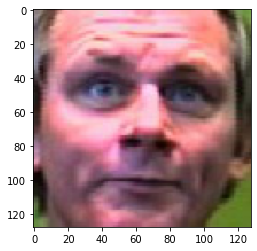

In [5]:
image = load_img('image/exemplo/aug_image.jpg', target_size=(128, 128))
plt.imshow(image);plt.show()

Exibindo algumas imagens transformadas

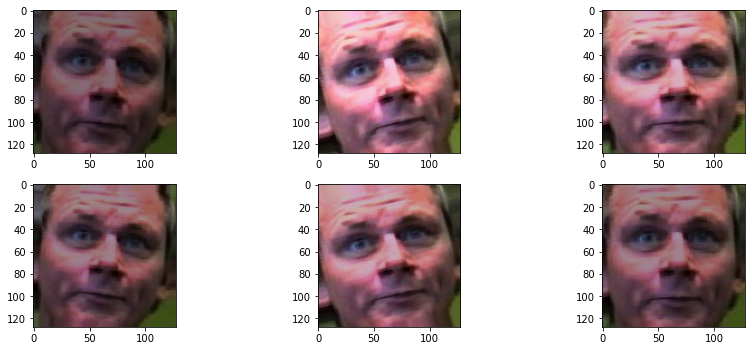

In [6]:
plt.figure(figsize=(12,12))
for i in range(0,6):
    plt.subplot(5, 3, i+1)
    batch = example_generator.next()
    plt.imshow(batch[0][0].astype('uint8'))
plt.tight_layout()
plt.show()

Como pode ser observado nas imagens e no código foram aplicadas transformações no zoom (bem pequena), no brilho e na rotação.

### Caregando os dados de treino

Aplicando data augmentation com as mesmas transformações menciadas na imagem de exemplo acima

In [17]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.05,
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory('Fotos_variadas/train/', 
                                                    target_size=(img_width, img_height),
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    seed=457)

Found 879 images belonging to 2 classes.


In [18]:
np.unique(train_generator.labels, return_counts=True)

(array([0, 1]), array([440, 439], dtype=int64))

Temos um total de 879 imagens para treino, sendo 440 imagens da classe 0 (olho aberto) e 439 da classe 1 (olho fechado)

### Caregando os dados de validação

In [19]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory('Fotos_variadas/test/', 
                                                              target_size=(img_width, img_height),
                                                              class_mode='categorical', 
                                                              color_mode='rgb',
                                                              batch_size=32,
                                                              shuffle=False)

Found 358 images belonging to 2 classes.


In [20]:
np.unique(validation_generator.labels, return_counts=True)

(array([0, 1]), array([174, 184], dtype=int64))

Temos um total de 358 imagens para validação, sendo 174 imagens da classe 0 (olho aberto) e 184 da classe 1 (olho fechado)

### Treinando redes neurais convolucionais

#### Definindo opções de treinamento

In [11]:
EPOCHS = 5
DROPOUT = 0.3
DENSE = 1024
NUM_CLASSES = 2

#### Definindo funções para auxiliar na verificação do desempenho dos modelos

##### Definindo função para plotar o histórico do "loss" e da acurácia

In [12]:
def Plota_Histórico_Treinamento(hist, epochs):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

##### Definindo função para calcular a matriz de confusão

In [13]:
def Calcula_Matriz_Confusao(model_aux, generator):
    probabilities = model_aux.predict_generator(generator=validation_generator)
    
    prob = []

    for i in range(len(probabilities)):
        if probabilities[i][0] > 0.5:
            prob.append(0)
        else:
            prob.append(1)
            
    y_true = generator.classes
    
    return confusion_matrix(y_true, prob)

##### Definindo função para realizar predições com algumas fotos de pessoas famosas para verificar a eficácia do modelo com imagens diferentes

Para isso, foram selecionadas 9 imagens de celebridades/famosos, então foi utilizado o método para recortar e manter somente a face da pessoa para deixar as imagens no padrão esperado pela rede neural

In [ ]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\famosos'

Corta_Face(directory, "predict")

In [14]:
def TestePredicaoFamosos(model):
    
    plt.figure(figsize=(12,12))
    
    for i in range(1,10):
        nome = 'predict/predict_' + str(i) + '.jpg'
        image_original = load_img(nome, target_size=(128, 128))
        
        # Converte a imagem em um array
        image = img_to_array(image_original)

        image = image/255

        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # Obtendo a classe predita
        pred = model.predict_classes(image)
        
        # Obtendo os graus de confiabilidade para cada classe
        pred_proba = model.predict(image)

        # Pegando a porcentagem de confiabilidade de pertencer a determinada classe
        conf = int((pred_proba[0][pred[0]]) * 100)
        
        plt.subplot(5, 3, i)
        
        if pred[0] == 0:
            plt.imshow(image_original);plt.title('Olho aberto - ' + str(conf) + '%');
        else:
            plt.imshow(image_original);plt.title('Olho fechado - ' + str(conf) + '%');
            
    plt.tight_layout()
    plt.show()


### Transfer Learning

#### Transfer Learning - Mobile Net

In [21]:
# Carrega o modelo sem as camadas de classificação
mobile_net = MobileNet(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

# Define as camadas em que não será feito o treinamento
for layer in mobile_net.layers:
  layer.trainable = False

mobile_net_model_tf = Sequential([mobile_net,
                                  Dropout(DROPOUT),
                                  Flatten(),
                                  Dense(DENSE, activation='relu'),
                                  Dense(NUM_CLASSES, activation='softmax')])

mobile_net_model_tf.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [22]:
hist_mobile_net_model_tf = mobile_net_model_tf.fit_generator(train_generator,
                                                             epochs=EPOCHS,
                                                             validation_data=validation_generator)

Epoch 1/5
28/28 [==============================] - 62s 2s/step - loss: 7.0832 - accuracy: 0.8658 - val_loss: 1.0953 - val_accuracy: 0.8045
Epoch 2/5
28/28 [==============================] - 62s 2s/step - loss: 0.5061 - accuracy: 0.9249 - val_loss: 0.7311 - val_accuracy: 0.8324
Epoch 3/5
28/28 [==============================] - 61s 2s/step - loss: 0.0607 - accuracy: 0.9829 - val_loss: 1.7728 - val_accuracy: 0.6927
Epoch 4/5
28/28 [==============================] - 62s 2s/step - loss: 0.0830 - accuracy: 0.9807 - val_loss: 1.1997 - val_accuracy: 0.7542
Epoch 5/5
28/28 [==============================] - 61s 2s/step - loss: 0.0205 - accuracy: 0.9920 - val_loss: 0.6530 - val_accuracy: 0.8352


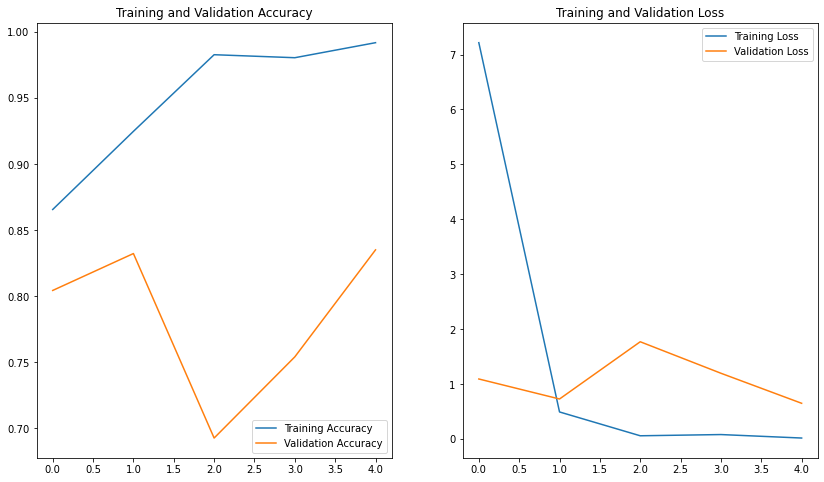

In [23]:
Plota_Histórico_Treinamento(hist_mobile_net_model_tf, EPOCHS)

In [24]:
mat = Calcula_Matriz_Confusao(mobile_net_model_tf, validation_generator)

print(mat)

[[174   0]
 [ 59 125]]


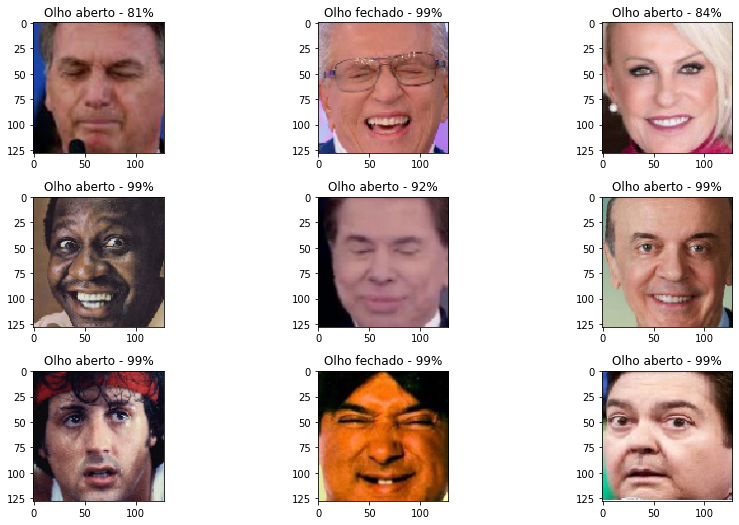

In [25]:
TestePredicaoFamosos(mobile_net_model_tf)

In [26]:
mobile_net_model_tf.save("mobile_net_model_tf")

#### Transfer Learning - Dense Net 121

In [27]:
# Carrega o modelo sem as camadas de classificação
densenet = DenseNet121(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

# Define as camadas em que não será feito o treinamento
for layer in densenet.layers:
  layer.trainable = False

densenet_model_tf = Sequential([densenet,
                                Dropout(DROPOUT),
                                Flatten(),
                                Dense(DENSE, activation='relu'),
                                Dense(NUM_CLASSES, activation='softmax')])

densenet_model_tf.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [28]:
hist_densenet_model_tf = densenet_model_tf.fit_generator(train_generator,
                                                         epochs=EPOCHS,
                                                         validation_data=validation_generator)

Epoch 1/5
28/28 [==============================] - 157s 6s/step - loss: 7.5525 - accuracy: 0.7691 - val_loss: 0.0505 - val_accuracy: 0.8687
Epoch 2/5
28/28 [==============================] - 153s 5s/step - loss: 0.1404 - accuracy: 0.9568 - val_loss: 0.0039 - val_accuracy: 0.9162
Epoch 3/5
28/28 [==============================] - 153s 5s/step - loss: 0.3484 - accuracy: 0.9192 - val_loss: 4.6688e-05 - val_accuracy: 0.8324
Epoch 4/5
28/28 [==============================] - 152s 5s/step - loss: 0.1673 - accuracy: 0.9602 - val_loss: 0.0115 - val_accuracy: 0.9190
Epoch 5/5
28/28 [==============================] - 151s 5s/step - loss: 0.0860 - accuracy: 0.9693 - val_loss: 0.0261 - val_accuracy: 0.9162


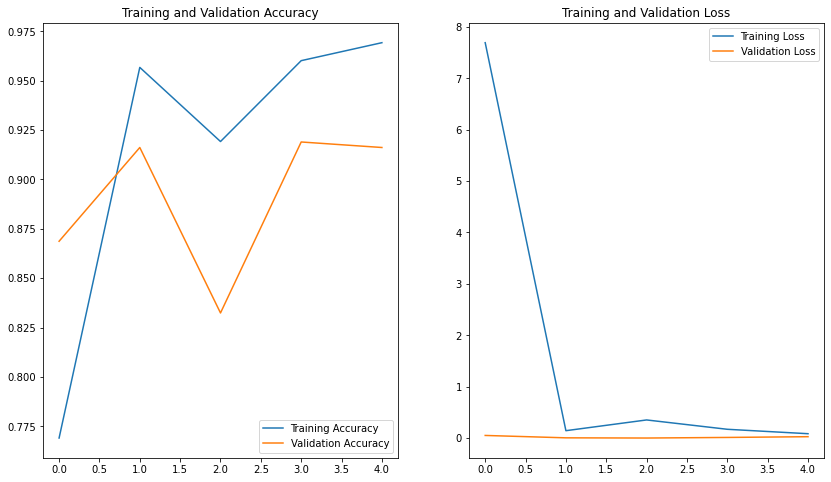

In [29]:
Plota_Histórico_Treinamento(hist_densenet_model_tf, EPOCHS)

In [30]:
mat = Calcula_Matriz_Confusao(densenet_model_tf, validation_generator)

print(mat)

[[168   6]
 [ 24 160]]


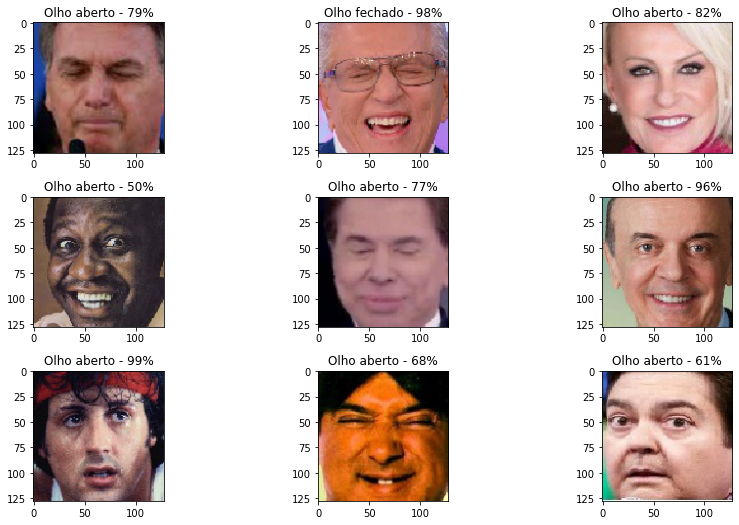

In [31]:
TestePredicaoFamosos(densenet_model_tf)

In [32]:
densenet_model_tf.save("densenet_model_tf")

#### Transfer Learning - Efficient Net B0

In [33]:
# Carrega o modelo sem as camadas de classificação
efficient_net = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

# Define as camadas em que não será feito o treinamento
for layer in efficient_net.layers:
  layer.trainable = False

efficient_net_model_tf = Sequential([efficient_net,
                                     Dropout(DROPOUT),
                                     Flatten(),
                                     Dense(DENSE, activation='relu'),
                                     Dense(NUM_CLASSES, activation='softmax')])

efficient_net_model_tf.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [34]:
hist_efficient_net_model_tf = efficient_net_model_tf.fit_generator(train_generator,
                                                                   epochs=EPOCHS,
                                                                   validation_data=validation_generator)

Epoch 1/5
28/28 [==============================] - 77s 3s/step - loss: 0.9333 - accuracy: 0.8828 - val_loss: 0.0042 - val_accuracy: 0.8073
Epoch 2/5
28/28 [==============================] - 79s 3s/step - loss: 0.2825 - accuracy: 0.9511 - val_loss: 0.1123 - val_accuracy: 0.7626
Epoch 3/5
28/28 [==============================] - 81s 3s/step - loss: 0.1275 - accuracy: 0.9681 - val_loss: 0.0294 - val_accuracy: 0.7682
Epoch 4/5
28/28 [==============================] - 77s 3s/step - loss: 0.1079 - accuracy: 0.9738 - val_loss: 7.0082e-04 - val_accuracy: 0.7598
Epoch 5/5
28/28 [==============================] - 78s 3s/step - loss: 0.1469 - accuracy: 0.9693 - val_loss: 0.0024 - val_accuracy: 0.7458


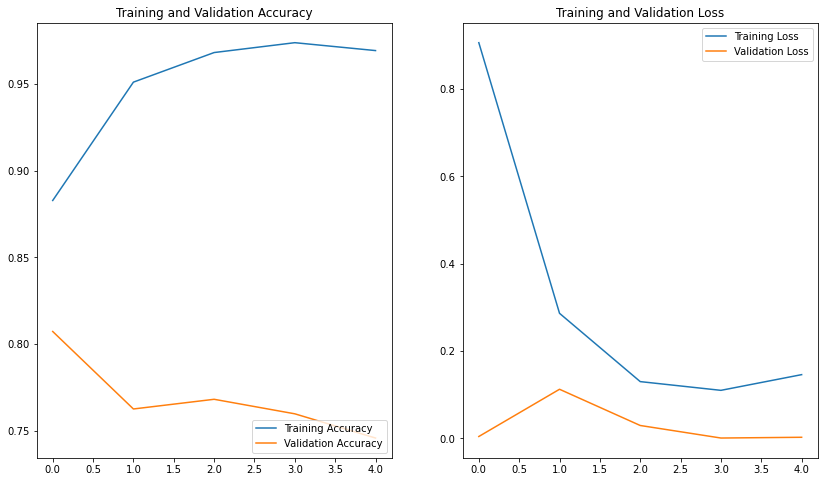

In [35]:
Plota_Histórico_Treinamento(hist_efficient_net_model_tf, EPOCHS)

In [36]:
mat = Calcula_Matriz_Confusao(efficient_net_model_tf, validation_generator)

print(mat)

[[ 98  76]
 [ 15 169]]


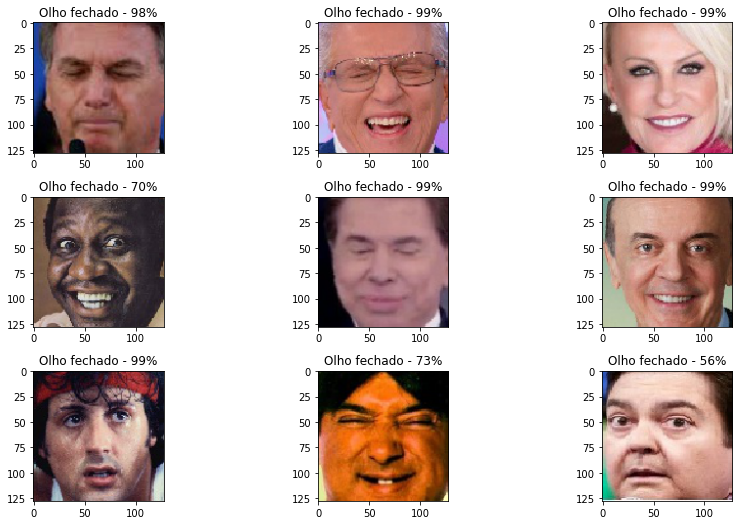

In [37]:
TestePredicaoFamosos(efficient_net_model_tf)

In [38]:
efficient_net_model_tf.save("efficient_net_model_tf")

### Treinando arquiteturas conhecidas

#### Mobile Net

In [39]:
# Carrega o modelo sem as camadas de classificação
mobile_net = MobileNet(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

mobile_net_model = Sequential([mobile_net,
                               Dropout(DROPOUT),
                               Flatten(),
                               Dense(DENSE, activation='relu'),
                               Dense(NUM_CLASSES, activation='softmax')])

mobile_net_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [40]:
hist = mobile_net_model.fit_generator(train_generator,
                                      epochs=EPOCHS,
                                      validation_data=validation_generator)

Epoch 1/5
28/28 [==============================] - 142s 5s/step - loss: 4.5286 - accuracy: 0.9044 - val_loss: 1.7641 - val_accuracy: 0.7151
Epoch 2/5
28/28 [==============================] - 140s 5s/step - loss: 0.0737 - accuracy: 0.9727 - val_loss: 1.6648 - val_accuracy: 0.7737
Epoch 3/5
28/28 [==============================] - 134s 5s/step - loss: 0.0844 - accuracy: 0.9795 - val_loss: 1.5497e-06 - val_accuracy: 0.9469
Epoch 4/5
28/28 [==============================] - 138s 5s/step - loss: 0.0294 - accuracy: 0.9954 - val_loss: 0.0000e+00 - val_accuracy: 0.9888
Epoch 5/5
28/28 [==============================] - 139s 5s/step - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.0000e+00 - val_accuracy: 0.9777


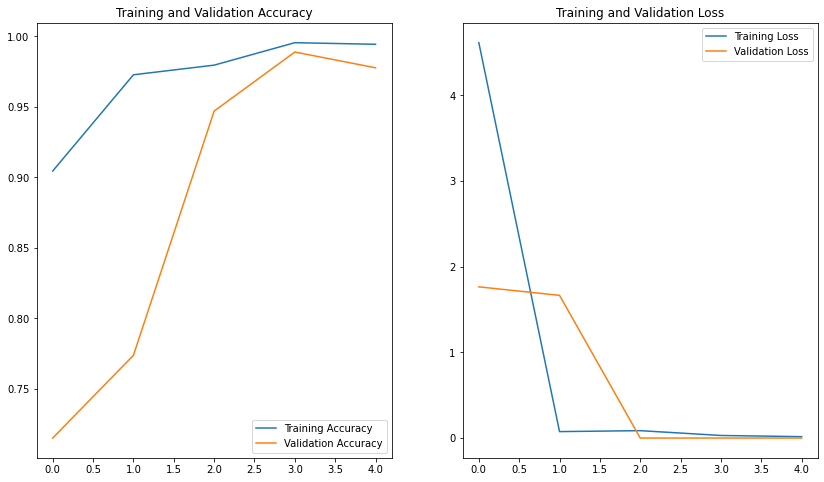

In [41]:
Plota_Histórico_Treinamento(hist, EPOCHS)

In [42]:
mat = Calcula_Matriz_Confusao(mobile_net_model, validation_generator)

print(mat)

[[166   8]
 [  0 184]]


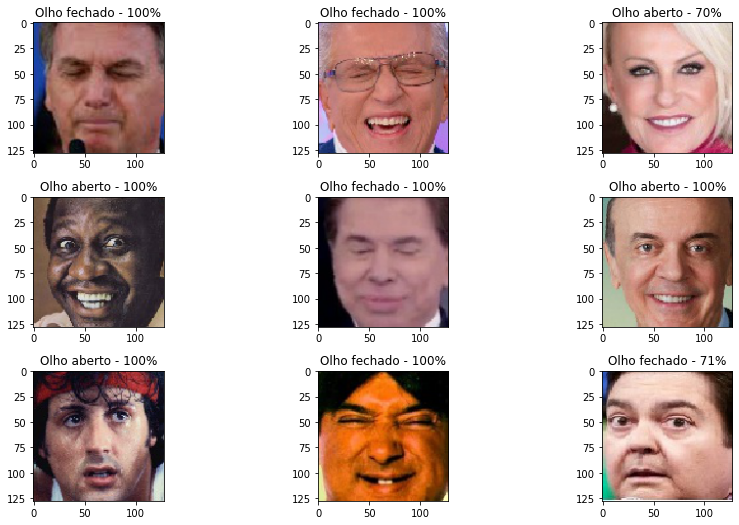

In [43]:
TestePredicaoFamosos(mobile_net_model)

In [44]:
mobile_net_model.save("mobile_net_model")

#### Dense Net 121

In [45]:
# Carrega o modelo sem as camadas de classificação
densenet = DenseNet121(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

densenet_model = Sequential([densenet,
                             Dropout(DROPOUT),
                             Flatten(),
                             Dense(DENSE, activation='relu'),
                             Dense(NUM_CLASSES, activation='softmax')])

densenet_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [46]:
hist_densenet_model = densenet_model.fit_generator(train_generator,
                                                   epochs=EPOCHS,
                                                   validation_data=validation_generator)

Epoch 1/5
28/28 [==============================] - 456s 16s/step - loss: 5.9779 - accuracy: 0.8578 - val_loss: 695.0926 - val_accuracy: 0.4665
Epoch 2/5
28/28 [==============================] - 403s 14s/step - loss: 0.0757 - accuracy: 0.9750 - val_loss: 0.0019 - val_accuracy: 0.9022
Epoch 3/5
28/28 [==============================] - 401s 14s/step - loss: 0.0360 - accuracy: 0.9898 - val_loss: 6.5167e-06 - val_accuracy: 0.8575
Epoch 4/5
28/28 [==============================] - 397s 14s/step - loss: 0.0103 - accuracy: 0.9977 - val_loss: 1.3073e-05 - val_accuracy: 0.9413
Epoch 5/5
28/28 [==============================] - 401s 14s/step - loss: 0.0228 - accuracy: 0.9920 - val_loss: 1.9868e-07 - val_accuracy: 0.9665


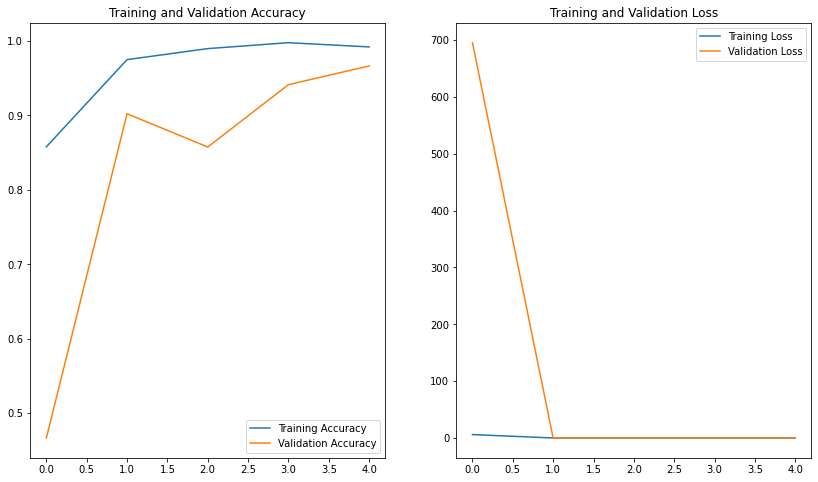

In [47]:
Plota_Histórico_Treinamento(hist_densenet_model, EPOCHS)

In [48]:
mat = Calcula_Matriz_Confusao(densenet_model, validation_generator)

print(mat)

[[162  12]
 [  0 184]]


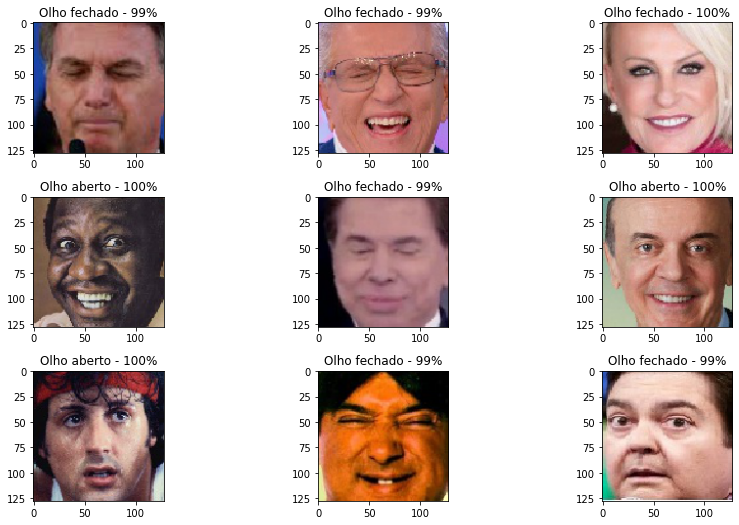

In [49]:
TestePredicaoFamosos(densenet_model)

In [50]:
densenet_model.save("densenet_model")

#### Efficient Net B0

In [51]:
# Carrega o modelo sem as camadas de classificação
efficient_net = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

efficient_net_model = Sequential([efficient_net,
                                  Dropout(DROPOUT),
                                  Flatten(),
                                  Dense(DENSE, activation='relu'),
                                  Dense(NUM_CLASSES, activation='softmax')])

efficient_net_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [52]:
hist_efficient_net_model = efficient_net_model.fit_generator(train_generator,
                                                             epochs=EPOCHS,
                                                             validation_data=validation_generator)

Epoch 1/5
28/28 [==============================] - 194s 7s/step - loss: 1.6430 - accuracy: 0.8953 - val_loss: 0.0648 - val_accuracy: 0.8492
Epoch 2/5
28/28 [==============================] - 177s 6s/step - loss: 0.0655 - accuracy: 0.9761 - val_loss: 0.0053 - val_accuracy: 0.7095
Epoch 3/5
28/28 [==============================] - 181s 6s/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 0.0033 - val_accuracy: 0.7682
Epoch 4/5
28/28 [==============================] - 178s 6s/step - loss: 0.0286 - accuracy: 0.9886 - val_loss: 3.9736e-08 - val_accuracy: 0.6564
Epoch 5/5
28/28 [==============================] - 191s 7s/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.0000e+00 - val_accuracy: 0.7877


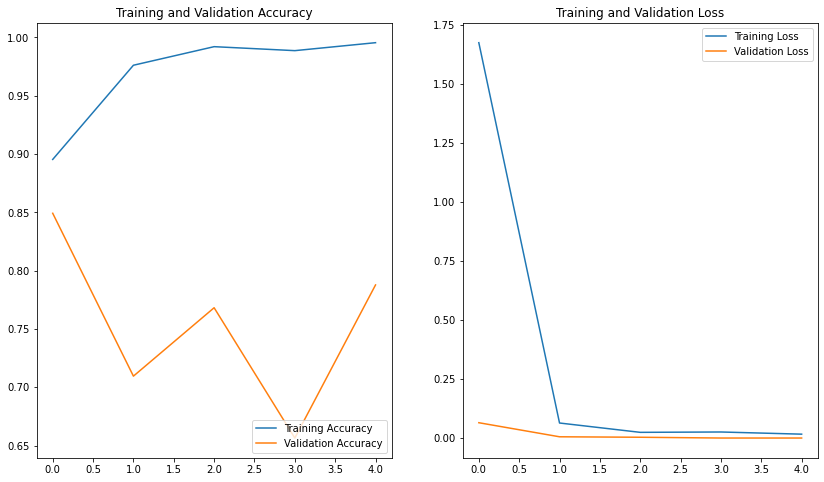

In [53]:
Plota_Histórico_Treinamento(hist_efficient_net_model, EPOCHS)

In [54]:
mat = Calcula_Matriz_Confusao(efficient_net_model, validation_generator)

print(mat)

[[ 98  76]
 [  0 184]]


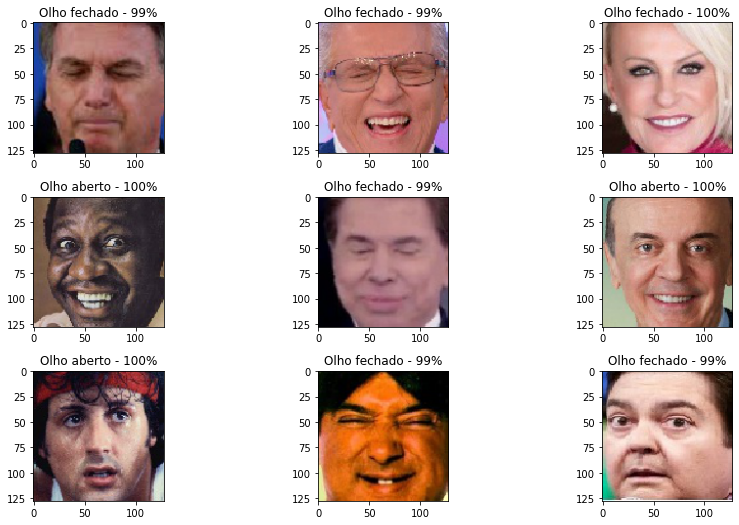

In [55]:
TestePredicaoFamosos(densenet_model)

In [56]:
efficient_net_model.save("efficient_net_model")

### Criando uma rede convolucional simples

In [57]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_width, img_height,3)))
model_cnn.add(MaxPooling2D())
model_cnn.add(Conv2D(32, 3, padding='same', activation='relu'))
model_cnn.add(MaxPooling2D())
model_cnn.add(Conv2D(64, 3, padding='same', activation='relu'))
model_cnn.add(MaxPooling2D())
model_cnn.add(Dropout(0.3))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [58]:
hist_cnn = model_cnn.fit_generator(train_generator,
                                   epochs=EPOCHS,
                                   validation_data=validation_generator)

Epoch 1/5
28/28 [==============================] - 19s 683ms/step - loss: 0.7561 - accuracy: 0.5677 - val_loss: 0.4952 - val_accuracy: 0.5698
Epoch 2/5
28/28 [==============================] - 19s 693ms/step - loss: 0.5388 - accuracy: 0.7270 - val_loss: 0.2271 - val_accuracy: 0.9330
Epoch 3/5
28/28 [==============================] - 20s 713ms/step - loss: 0.4382 - accuracy: 0.8339 - val_loss: 0.2731 - val_accuracy: 0.8939
Epoch 4/5
28/28 [==============================] - 20s 702ms/step - loss: 0.3416 - accuracy: 0.8476 - val_loss: 0.2479 - val_accuracy: 0.9218
Epoch 5/5
28/28 [==============================] - 22s 777ms/step - loss: 0.2894 - accuracy: 0.8703 - val_loss: 0.3815 - val_accuracy: 0.8687


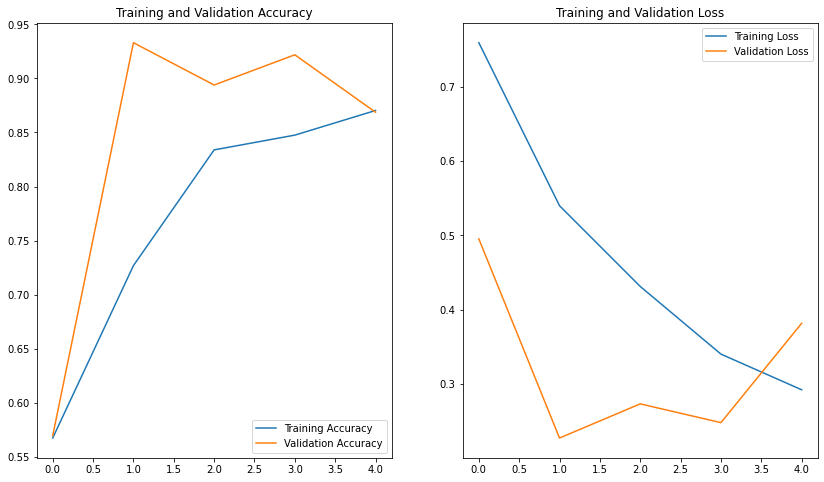

In [59]:
Plota_Histórico_Treinamento(hist_cnn, EPOCHS)

In [60]:
mat = Calcula_Matriz_Confusao(model_cnn, validation_generator)

print(mat)

[[168   6]
 [ 41 143]]


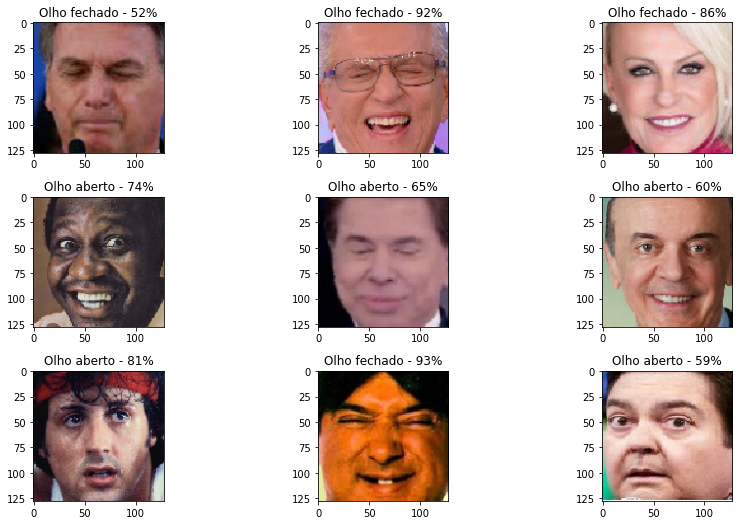

In [61]:
TestePredicaoFamosos(model_cnn)

In [62]:
model_cnn.save("model_cnn")

### Comparação dos resultados obtidos pelas CNN (Convolutional Neural Network)

<table border="1" backgroundcolor='black'>
<tr>
<th>Arquitetura Rede</th>
<th>Transfer Learning</th>
<th>Acurácia - Treino</th>
<th>Acurácia - Validação</th>
<th>Acertos nos famosos</th>
<th>Tempo de Execução (segundos)</th>
<th>Comentário</th>
    
</tr>
<tr>
<td>Mobile Net</td>
<td>Sim</td>
<td>99%</td>
<td>83%</td>
<td>7 de 9</td>
<td>308</td>
<td></td>
</tr>
<tr>
<tr>
<td>Dense Net 121</td>
<td>Sim</td>
<td>96%</td>
<td>91%</td>
<td>6 de 9</td>
<td>766</td>
<td></td>
</tr>
<tr>
<td>Efficient Net B0</td>
<td>Sim</td>
<td>96%</td>
<td>74%</td>
<td>4 de 9</td>
<td>392</td>
<td>Classificou todas as fotos dos famosos como "olho fechado"</td>
</tr>
<tr>
<td>Mobile Net</td>
<td>Não</td>
<td>99%</td>
<td>97%</td>
<td>8 de 9</td>
<td>693</td>
<td>Melhor desempenho</td>
</tr>
<tr>
<td>Dense Net 121</td>
<td>Não</td>
<td>99%</td>
<td>96%</td>
<td>7 de 9</td>
<td>2058</td>
<td>A mais demorada para treinar</td>
</tr>
<tr>
<td>Efficient Net B0</td>
<td>Não</td>
<td>99%</td>
<td>78%</td>
<td>7 de 9</td>
<td>921</td>
<td></td>
</tr>
<tr>
<td>CNN simples</td>
<td>Não</td>
<td>87%</td>
<td>86%</td>
<td>7 de 9</td>
<td>100</td>
<td>Mesmo fazendo 7 classificações certas nos famosos, algumas dessas apresentam uma baixa confiabilidade</td>
</tr>
</table>

Observação: O treinamento foi realizado usando CPU, utilizando GPU com certeza o tempo seria reduzido

### Carregando o modelo que obtive o melhor desempenho para ser usado na simulação com vídeo

In [2]:
mobile_net_model = load_model('mobile_net_model')

### Validando o modelo com video

In [3]:
# Carregando o modelo de detecção
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Habilitando webcam para capturar frames do vídeo 
cap = cv2.VideoCapture(0)

while True:
    # Lendo frame
    _, img = cap.read()
    
    # Convertendo frame para escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detectando face
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    if len(faces) != 1: 
        
        position = (10,50)
        cv2.putText(img, 'Nenhuma/multiplas faces', position, 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (209, 80, 0, 255), 3) 

        # Mostrando a imagem 
        cv2.imshow('Detectando sonolencia', img)

        # Interrompe a execução se apertado ESC
        k = cv2.waitKey(30) & 0xff
        if k==27:
            break
    else:        
    # Desenha retângulo e corta somente a face para ser usada na predição
        for (x, y, w, h) in faces:
            face_crop = img[y:y+h, x:x+w]
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Preparando a imagem para fazer uma predição
        face_crop = cv2.resize(face_crop, (128, 128)) 
        face_crop = face_crop/255
        face_crop = face_crop.reshape((1, face_crop.shape[0], face_crop.shape[1], face_crop.shape[2]))

        # Fazendo a predição
        pred = mobile_net_model.predict_classes(face_crop)  

        if pred[0] == 0:
            nome_classe = 'Olho aberto'
        else:
            nome_classe = 'Olho fechado'

        position = (10,50)

        cv2.putText(img, nome_classe, position, cv2.FONT_HERSHEY_SIMPLEX, 1, (209, 80, 0, 255), 3) 

        # Mostrando a imagem 
        cv2.imshow('Detectando sonolencia', img)

        # Interrompe a execução se apertado ESC
        k = cv2.waitKey(30) & 0xff
        if k==27:
            break

# Parando a execução e desabilitando a camera
cv2.destroyAllWindows()
cap.release()

### Referências bibliográficas

AUTOPAPO. Mais de 40% dos acidentes de trânsito acontecem por sonolência, 2019. Disponível em: https://autopapo.uol.com.br/noticia/mais-de-40-dos-acidentes-de-transito-acontece-por-sonolencia-afirma-a-abramet/. Acesso em: 22 out. 2020.

BATISTA, L. E. Pesquisas indicam que sono na direção pode ser tão perigoso quanto álcool, 2017. Disponível em: http://www1.folha.uol.com.br/sobretudo/rodas/2017/03/1869609-pesquisas-indicam-que-sono-na-direcao-pode-ser-tao-perigoso-quanto-alcool.shtml. Acesso em: 22 out. 2020.